# TC6004 Machine Learning
# Homework - Evaluation and classification
February 23th, 2026


*
* Adrian Pineda Sanchez - A00834710
* Naila Itzel Salinas Alfaro - A00832702
* Jesús Antonio Low Castro - A00840713


# Dependencies * It must be cleaned at the end*

First, we import all necessary python modules:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn

# Datasets
from sklearn import datasets
from sklearn.datasets import fetch_openml

# Utilities
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize, OneHotEncoder

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    matthews_corrcoef,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
)

plt.style.use("ggplot")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score

# Abstract

TO DO

# Introduction

## Models Evaluated

The following classification algorithms are included in the experimental comparison:

- Decision Tree (entropy criterion)
- k-Nearest Neighbors (k-NN)
- Linear Discriminant Analysis (LDA – Fisher)
- Random Forest
- Support Vector Machine (RBF kernel)
- Logistic Regression
- Gradient Boosted Trees

All models use a fixed `random_state = 42` where applicable to ensure reproducibility.


## Evaluation Metrics Reported

After selecting the best hyperparameter configuration via cross-validation, each model is evaluated on the held-out test set using the following metrics:

- Accuracy  
- Balanced Accuracy  
- Precision  
- Recall  
- F1 Score  
- Matthews Correlation Coefficient (MCC)  
- ROC AUC (micro-average)  
- ROC AUC (macro-average)  
- Precision–Recall AUC / Average Precision (micro-average)  
- Precision–Recall AUC / Average Precision (macro-average)

These metrics provide complementary perspectives:

- **Accuracy** reflects overall correctness.
- **Balanced Accuracy** compensates for class imbalance.
- **Macro-averaged metrics** treat all classes equally.
- **Micro-averaged metrics** aggregate contributions across classes.
- **MCC** provides a correlation-based measure that remains informative under class imbalance.
- **ROC AUC and PR AUC** evaluate ranking performance across decision thresholds.

## Training Setup
As discussed previously, multiple classification models must be evaluated on both balanced and unbalanced datasets.
To ensure a fair and reproducible comparison, a standardized training and evaluation pipeline is adopted for all datasets, as outlined below.

## Stratified train–test split
The dataset is divided into training and test subsets using a stratified split.
This preserves the original class distribution in both subsets, which is especially important when dealing with class imbalance.

## Model training with random search and cross-validation
Each model is trained using Randomized Search combined with stratified k-fold cross-validation.
For each classifier, a fixed number of hyperparameter configurations is sampled, and performance is evaluated using the selected cross-validation scoring metric.

## Hyperparameter selection
For every model, the hyperparameter configuration that achieves the best average cross-validation score is selected.
This configuration defines the final version of the model used for testing.

## Final evaluation and metric reporting
The best-performing model for each classifier is evaluated once on the held-out test set.
Relevant performance metrics and visualizations are computed and reported to allow direct comparison between models.

## Configurations

In [ ]:
col_order = [
    "Accuracy", "Balanced Accuracy", "Precision", "Recall", "F1", "MCC",
    "ROC AUC (micro)", "ROC AUC (macro)", "PR AUC/AP (micro)", "PR AUC/AP (macro)"
]

# CV strategy (stratified)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = "f1_macro"

models = {
    "Decision Tree (entropy)": DecisionTreeClassifier(
        criterion="entropy", random_state=42
    ),

    "k-NN (k=5)": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]),
    "LDA (Fisher)": Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis())
    ]),
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=42))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "Gradient Boosted Trees": GradientBoostingClassifier(
        random_state=42
    ),
}

# Random search spaces
param_distributions = {
    "Decision Tree (entropy)": {
        "max_depth": [None, 2, 3, 4, 5, 8],
        "min_samples_split": randint(2, 11),   # 2..10
        "min_samples_leaf": randint(1, 5),     # 1..4
        "ccp_alpha": loguniform(1e-6, 1e-2),   # continuous, mostly near 0
    },
    "k-NN (k=5)": {
        "knn__n_neighbors": randint(1, 31),    # 1..30
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2],                      # Manhattan / Euclidean
    },
    "LDA (Fisher)": {
        "lda__solver": ["svd", "lsqr", "eigen"],
    },
    "Random Forest": {
        "n_estimators": randint(200, 901),     # 200..900
        "max_depth": [None, 3, 5, 8, 12],
        "min_samples_split": randint(2, 21),   # 2..20
        "min_samples_leaf": randint(1, 6),     # 1..5
        "max_features": ["sqrt", "log2", None],
    },
    "SVM (RBF)": {
        "svm__C": loguniform(1e-2, 1e2),       # 0.01..100
        "svm__gamma": ["scale", "auto", 0.01, 0.1, 1.0],
        "svm__class_weight": [None, "balanced"],
    },
    "Logistic Regression": {
        "lr__C": loguniform(1e-2, 1e2),        # 0.01..100
        "lr__penalty": ["l2"],
        "lr__solver": ["lbfgs", "liblinear"],
        "lr__class_weight": [None, "balanced"],
    },

    "Gradient Boosted Trees": {
        "n_estimators": randint(80, 501),      # 80..500
        "learning_rate": loguniform(1e-2, 2e-1),  # 0.01..0.2
        "max_depth": randint(1, 4),            # 1..3
        "subsample": uniform(0.6, 0.4),        # 0.6..1.0
        "min_samples_leaf": randint(1, 6),     # 1..5
    },
}

# Functions

In [ ]:
def class_distribution_report(X, y, dataset_name=None):
    """
    Display dataset summary information and visualize class distribution.

    This function:
    - Prints basic dataset diagnostics (shape, missing values, categorical columns)
    - Displays a table with class counts and proportions
    - Plots a bar chart of class counts to assess class imbalance

    Parameters
    ----------
    X : pandas.DataFrame
        Feature matrix. Used to report shape, missing values, and categorical columns.
    y : array-like or pandas.Series
        Target labels corresponding to X.
    dataset_name : str, optional
        Name of the dataset, used in the plot title.

    Notes
    -----
    - Supports binary and multiclass classification.
    - Class proportions are shown numerically (not normalized in the plot)
      to avoid visually hiding imbalance.
    - Assumes X is a pandas DataFrame (uses .isnull() and .select_dtypes()).
    """

    print("Shape:", X.shape, y.shape)
    print("Missing values:", X.isnull().sum().sum())
    print("Categorical columns:", X.select_dtypes(include=['object']).columns.tolist())

    print()
    # Explicit Numeric Feedback
    class_counts = y.value_counts().sort_index()
    class_props = (class_counts / class_counts.sum()).round(1)

    table = pd.DataFrame({
        "Class": class_counts.index,
        "Count": class_counts.values,
        "Proportion": class_props.values
    })
    display(table)

    print()
    # Class Distribution Plot
    plt.figure()
    plt.bar(class_counts.index.astype(str), class_counts.values)
    plt.title(f"Class distribution: {dataset_name}")
    plt.xlabel("Class label")
    plt.ylabel("Number of samples")
    plt.show()

In [ ]:
def evaluate_classifier_with_plots(
    model,
    X_test,
    y_test,
    average="auto",
    pos_label=1,
    class_names=None,
    title=None
):
    """
    Returns ONE-row metrics dict (suitable for building a merged table across models)
    and produces ONE figure with 3 subplots:
        * Confusion Matrix
        * ROC Curve (+ AUC)
        * Precision–Recall Curve (+ AP)

    Metrics returned
    ---------------
    Accuracy, Precision, Recall, F1, Balanced Accuracy, MCC,
    ROC AUC (micro/macro), PR AUC/AP (micro/macro)

    Notes
    -----
    - Binary: ROC/PR computed for pos_label.
    - Multiclass: plots micro-average ROC/PR curves; returns micro+macro summaries.
    - Curves require predict_proba or decision_function; if missing, curves are skipped (NaN in table).
    """
    y_true = np.asarray(y_test)
    y_pred = np.asarray(model.predict(X_test))

    classes = np.unique(y_true)
    n_classes = len(classes)

    # averaging strategy for P/R/F1
    if average == "auto":
        avg_use = "binary" if n_classes == 2 else "macro"
    else:
        avg_use = average

    # core metrics
    metrics = {}
    metrics["Accuracy"] = accuracy_score(y_true, y_pred)
    metrics["Balanced Accuracy"] = balanced_accuracy_score(y_true, y_pred)
    metrics["MCC"] = matthews_corrcoef(y_true, y_pred)

    if avg_use == "binary":
        metrics["Precision"] = precision_score(y_true, y_pred, average="binary", pos_label=pos_label, zero_division=0)
        metrics["Recall"] = recall_score(y_true, y_pred, average="binary", pos_label=pos_label, zero_division=0)
        metrics["F1"] = f1_score(y_true, y_pred, average="binary", pos_label=pos_label, zero_division=0)
    else:
        metrics["Precision"] = precision_score(y_true, y_pred, average=avg_use, zero_division=0)
        metrics["Recall"] = recall_score(y_true, y_pred, average=avg_use, zero_division=0)
        metrics["F1"] = f1_score(y_true, y_pred, average=avg_use, zero_division=0)

    # Defaults for curve metrics
    metrics["ROC AUC (micro)"] = np.nan
    metrics["ROC AUC (macro)"] = np.nan
    metrics["PR AUC/AP (micro)"] = np.nan
    metrics["PR AUC/AP (macro)"] = np.nan

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    display_labels = class_names if class_names is not None else classes

    # scores for curves
    scores = None
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_test)

    # plot: 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Confusion matrix (make it readable under ggplot-like styles)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=axes[0], colorbar=False, values_format="d")
    axes[0].grid(False)
    axes[0].set_facecolor("white")
    axes[0].set_title(f"{title + ' - ' if title else ''}Confusion Matrix")

    # ROC axis setup
    axes[1].set_title(f"{title + ' - ' if title else ''}ROC Curve")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].plot([0, 1], [0, 1], linestyle="--")

    # PR axis setup
    axes[2].set_title(f"{title + ' - ' if title else ''}Precision–Recall Curve")
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")

    if scores is None:
        axes[1].text(0.5, 0.5, "No predict_proba/decision_function", ha="center", va="center")
        axes[2].text(0.5, 0.5, "No predict_proba/decision_function", ha="center", va="center")
    else:
        scores = np.asarray(scores)

        if n_classes == 2:
            # Choose score for positive class
            if scores.ndim == 2:
                if hasattr(model, "classes_") and pos_label in model.classes_:
                    pos_idx = int(np.where(model.classes_ == pos_label)[0][0])
                else:
                    pos_idx = 1
                s = scores[:, pos_idx]
            else:
                s = scores.ravel()

            # ROC curve + AUC
            fpr, tpr, _ = roc_curve(y_true, s, pos_label=pos_label)
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
            axes[1].legend(loc="lower right")
            metrics["ROC AUC (micro)"] = roc_auc
            metrics["ROC AUC (macro)"] = roc_auc

            # PR curve + AP
            pr_prec, pr_rec, _ = precision_recall_curve(y_true, s, pos_label=pos_label)
            ap = average_precision_score(y_true, s, pos_label=pos_label)
            axes[2].plot(pr_rec, pr_prec, label=f"AP = {ap:.4f}")
            axes[2].legend(loc="lower left")
            metrics["PR AUC/AP (micro)"] = ap
            metrics["PR AUC/AP (macro)"] = ap

        else:
            # Multiclass micro-average ROC/PR
            if scores.ndim == 1:
                axes[1].text(0.5, 0.5, "Need per-class scores", ha="center", va="center")
                axes[2].text(0.5, 0.5, "Need per-class scores", ha="center", va="center")
            else:
                y_bin = label_binarize(y_true, classes=classes)

                # ROC micro curve
                fpr, tpr, _ = roc_curve(y_bin.ravel(), scores.ravel())
                roc_auc_micro = auc(fpr, tpr)
                axes[1].plot(fpr, tpr, label=f"micro AUC = {roc_auc_micro:.4f}")
                axes[1].legend(loc="lower right")
                metrics["ROC AUC (micro)"] = roc_auc_micro

                # ROC macro AUC (OVR)
                try:
                    metrics["ROC AUC (macro)"] = roc_auc_score(
                        y_true, scores, multi_class="ovr", average="macro"
                    )
                except Exception:
                    metrics["ROC AUC (macro)"] = np.nan

                # PR micro curve
                pr_prec, pr_rec, _ = precision_recall_curve(y_bin.ravel(), scores.ravel())
                ap_micro = average_precision_score(y_bin, scores, average="micro")
                ap_macro = average_precision_score(y_bin, scores, average="macro")
                axes[2].plot(pr_rec, pr_prec, label=f"micro AP = {ap_micro:.4f}")
                axes[2].legend(loc="lower left")
                metrics["PR AUC/AP (micro)"] = ap_micro
                metrics["PR AUC/AP (macro)"] = ap_macro

    plt.tight_layout()
    plt.show()

    return metrics

In [ ]:
def tune_and_evaluate_models_random_search(
    models,
    param_distributions,
    X_train,
    y_train,
    X_test,
    y_test,
    cv,
    scoring,
    evaluate_fn,
    class_names,
    max_trials_per_model=30,
    random_state=42,
    n_jobs=-1,
    verbose=0,
):
    """
    Tune multiple models using RandomizedSearchCV and evaluate on a held-out test set.

    Returns
    -------
    tuned_models : dict
        {model_name: fitted_best_estimator}
    rows : list of dict
        Evaluation results + CV score + best params per model
    """

    tuned_models = {}
    rows = []

    for name, model in models.items():
        dist = param_distributions.get(name)

        if dist is None:
            # No hyperparameter tuning
            best_model = model.fit(X_train, y_train)
            best_params = None
            best_cv_score = None
        else:
            search = RandomizedSearchCV(
                estimator=model,
                param_distributions=dist,
                n_iter=max_trials_per_model,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs,
                refit=True,
                random_state=random_state,
                verbose=verbose,
            )
            search.fit(X_train, y_train)

            best_model = search.best_estimator_
            best_params = search.best_params_
            best_cv_score = search.best_score_

        tuned_models[name] = best_model

        row = evaluate_fn(
            best_model,
            X_test,
            y_test,
            class_names=class_names,
            title=name,
        )
        row["Model"] = name
        row["CV_best_score"] = best_cv_score
        row["Best_params"] = best_params
        rows.append(row)

    return tuned_models, rows

# Iris Dataset (balanced)

The Iris Dataset is a classic, small dataset widely used in statistics and machine learning for benchmarking classification algorithms. It was introduced by the statistician Ronald A. Fisher in 1936. The dataset consists of 150 observations, equally divided into three classes, with 50 samples per class. These classes correspond to three iris flower species: Iris setosa, Iris versicolor, and Iris virginica. Each sample represents measurements taken from a single flower and includes four numerical features measured in centimeters: sepal length, sepal width, petal length, and petal width.

The dataset is known for having one clearly separable class and two classes that partially overlap. This makes it useful for analyzing how different algorithms handle varying levels of separability. Iris serves as a clear baseline dataset before evaluating models on more complex or imbalanced problems.



## Data Processing

In [ ]:
# Data Loading
iris = datasets.load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target

# Display Iris Dataframe
display(iris.frame)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


Shape: (150, 4) (150,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,50,0.3
1,1,50,0.3
2,2,50,0.3


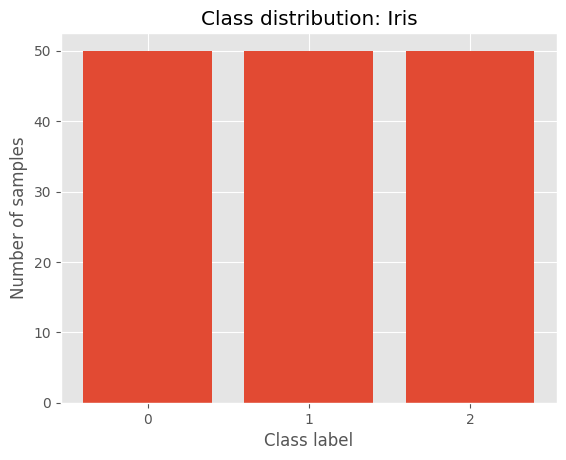

In [ ]:
# Class Distribution Analysis
class_distribution_report(X_iris, y_iris, "Iris")

## Model Training and Evaluation

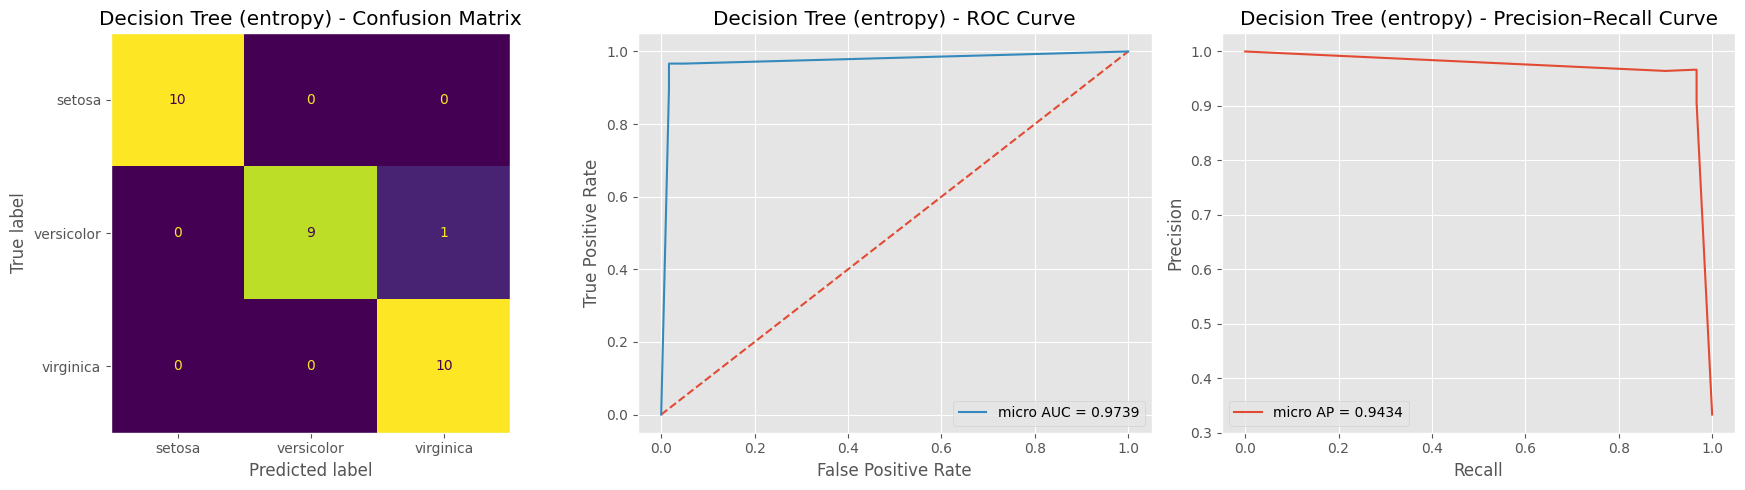

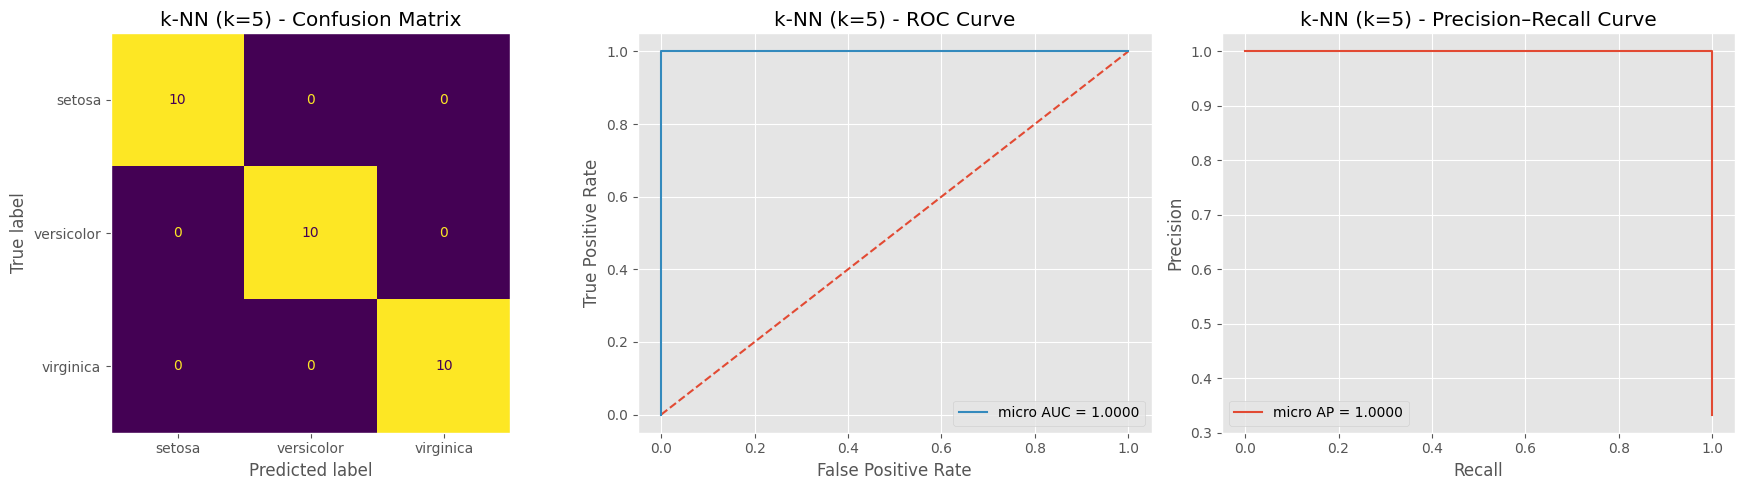

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


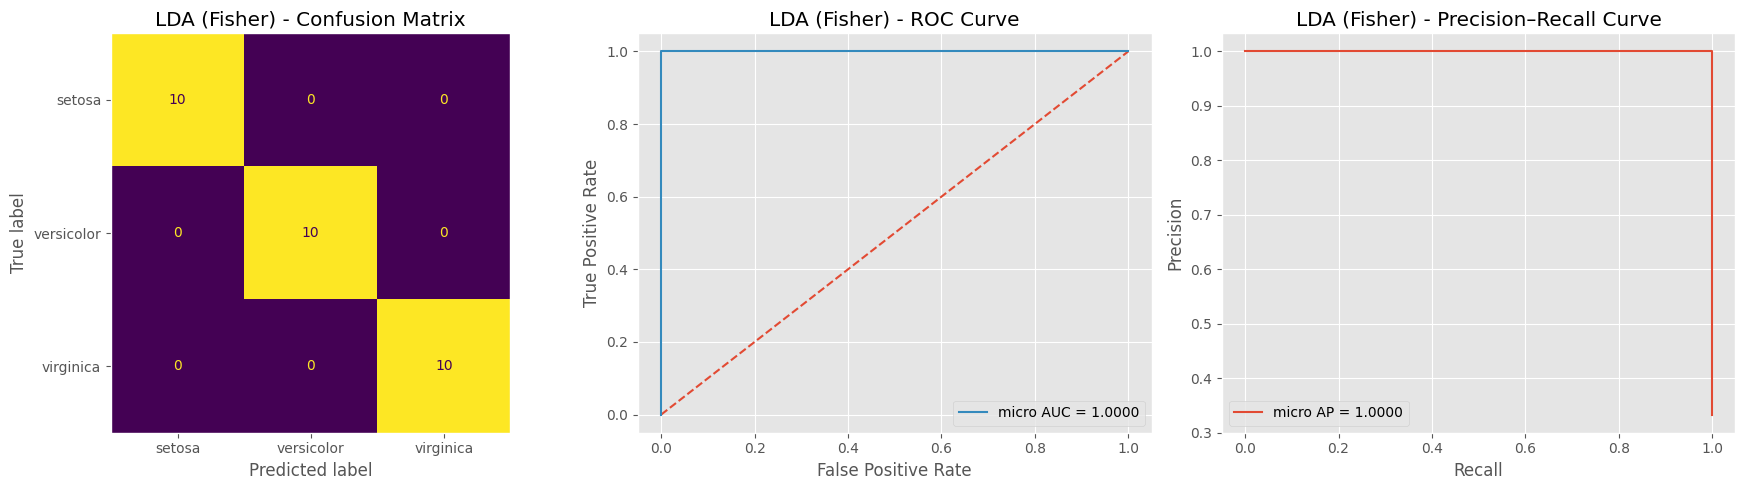

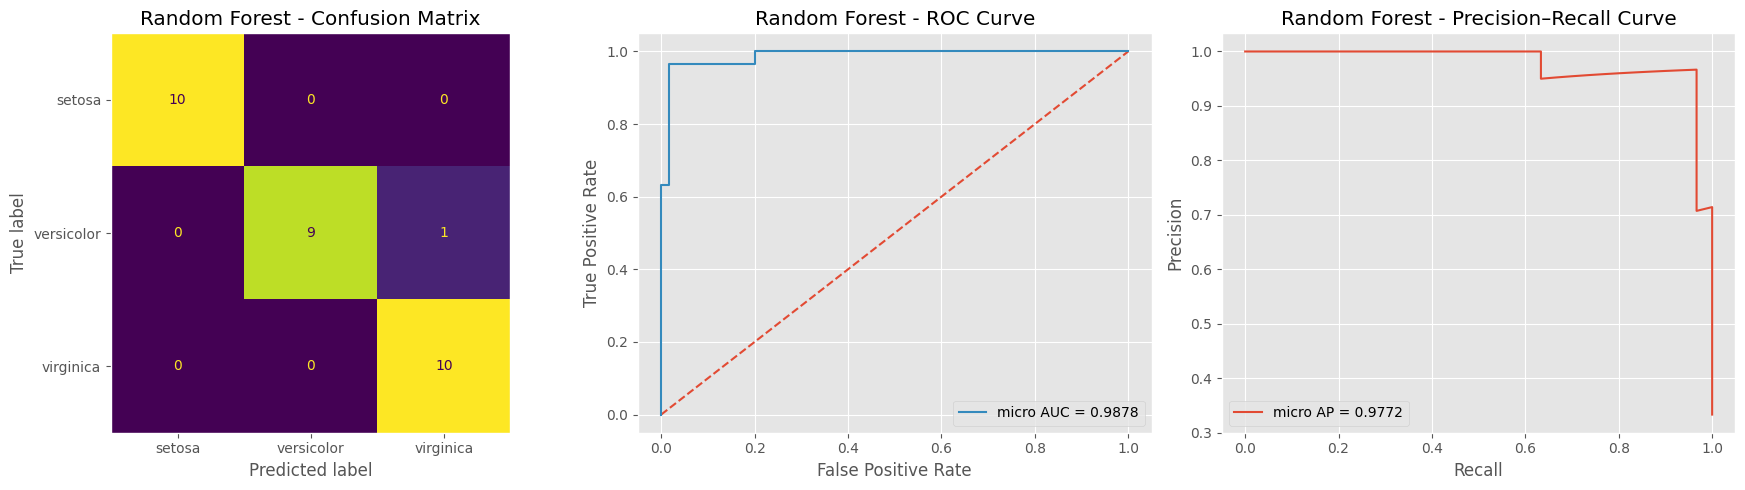

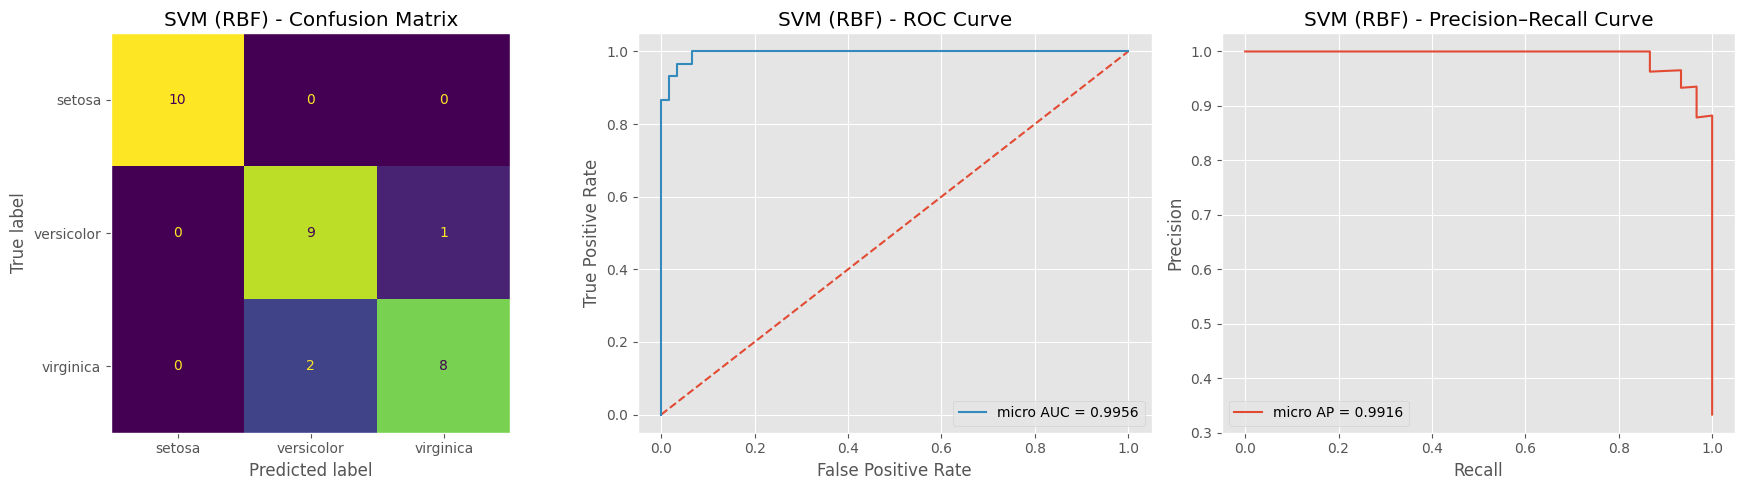

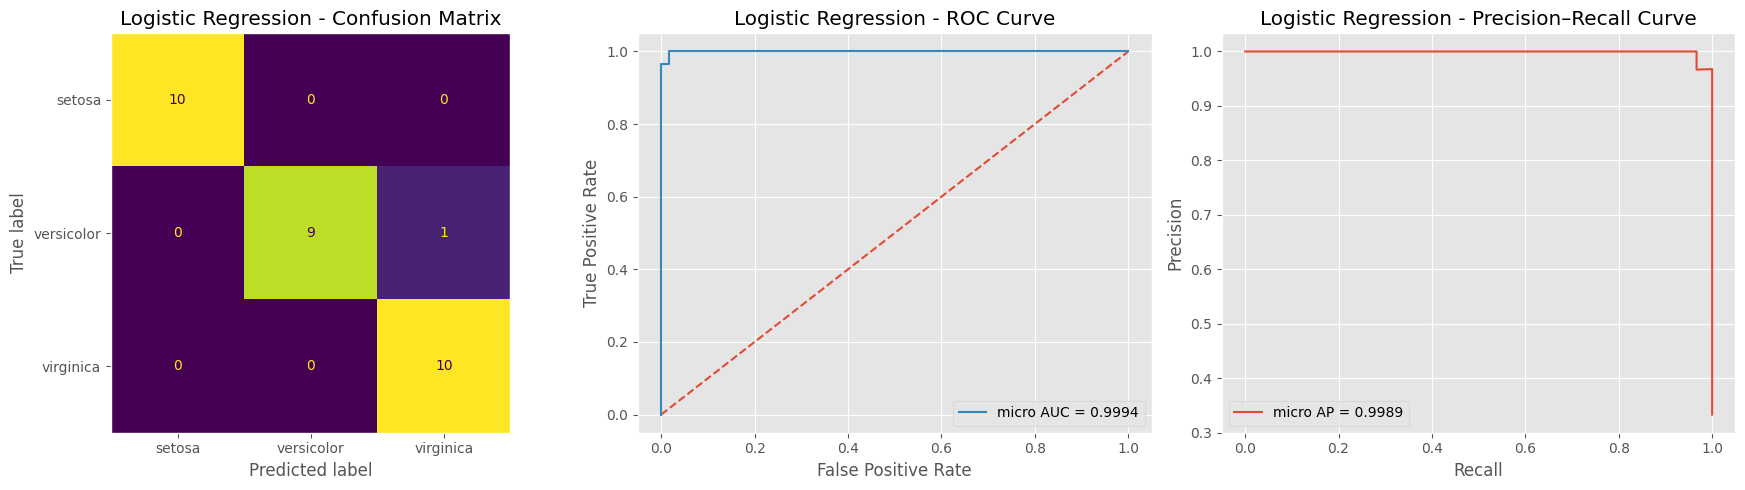

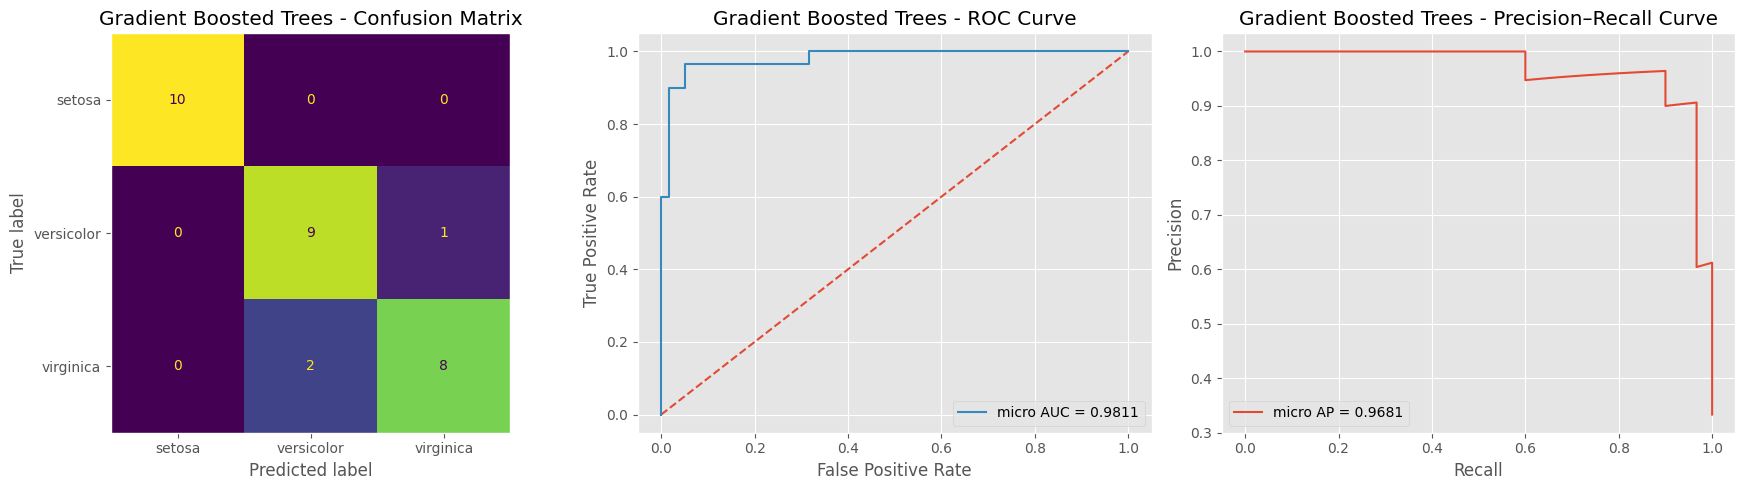

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.2, random_state=42, stratify=y_iris
)

tuned_models, rows = tune_and_evaluate_models_random_search(
    models=models,
    param_distributions=param_distributions,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    evaluate_fn=evaluate_classifier_with_plots,
    class_names=iris.target_names,
    max_trials_per_model=30,
)

In [ ]:
# Metrics Table
iris_metrics = pd.DataFrame(rows).set_index("Model")[col_order].round(3)
display(iris_metrics)

,Accuracy,Balanced Accuracy,Precision,Recall,F1,MCC,ROC AUC (micro),ROC AUC (macro),PR AUC/AP (micro),PR AUC/AP (macro)
Model,,,,,,,,,,
Decision Tree (entropy),0.967,0.967,0.970,0.967,0.967,0.952,0.974,0.972,0.943,0.942
k-NN (k=5),1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
LDA (Fisher),1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
Random Forest,0.967,0.967,0.970,0.967,0.967,0.952,0.988,0.987,0.977,0.979
SVM (RBF),0.900,0.900,0.902,0.900,0.900,0.851,0.996,0.990,0.992,0.982
Logistic Regression,0.967,0.967,0.970,0.967,0.967,0.952,0.999,1.000,0.999,1.000
Gradient Boosted Trees,0.900,0.900,0.902,0.900,0.900,0.851,0.981,0.987,0.968,0.979


## Discussion

As we can see on the data anylsisi. The dataset is class-balanced containing 50 samples per class.

After training and evaluating the models

# Breast Cancer Dataset (balanced)

The Breast Cancer Wisconsin Diagnostic dataset was chosen as a balanced binary classification problem with real medical relevance. It contains 569 samples labeled as malignant or benign tumors. Although the classes are not perfectly equal, the distribution is reasonably balanced, allowing standard performance metrics to remain informative.

Each sample includes 30 numerical features extracted from digitized medical images, describing characteristics of cell nuclei such as size, texture, and shape. The dataset introduces higher dimensionality compared to Iris and represents a realistic diagnostic scenario. It allows us to evaluate how classifiers perform in a binary setting where correct identification of tumor type is important. This dataset complements Iris by providing a more complex and practical classification task within a balanced context.

## Data Processing

In [ ]:
# Data Loading
breast = datasets.load_breast_cancer(as_frame=True)
X_breast = breast.data
y_breast = breast.target

# Display DataFrame
display(breast.frame)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


Shape: (569, 30) (569,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,212,0.4
1,1,357,0.6


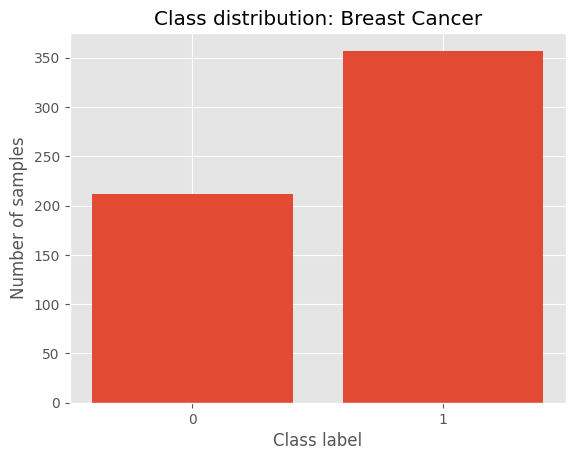

In [ ]:
# Class Distribution Analysis
class_distribution_report(X_breast, y_breast, "Breast Cancer")

## Model Training and Evaluation

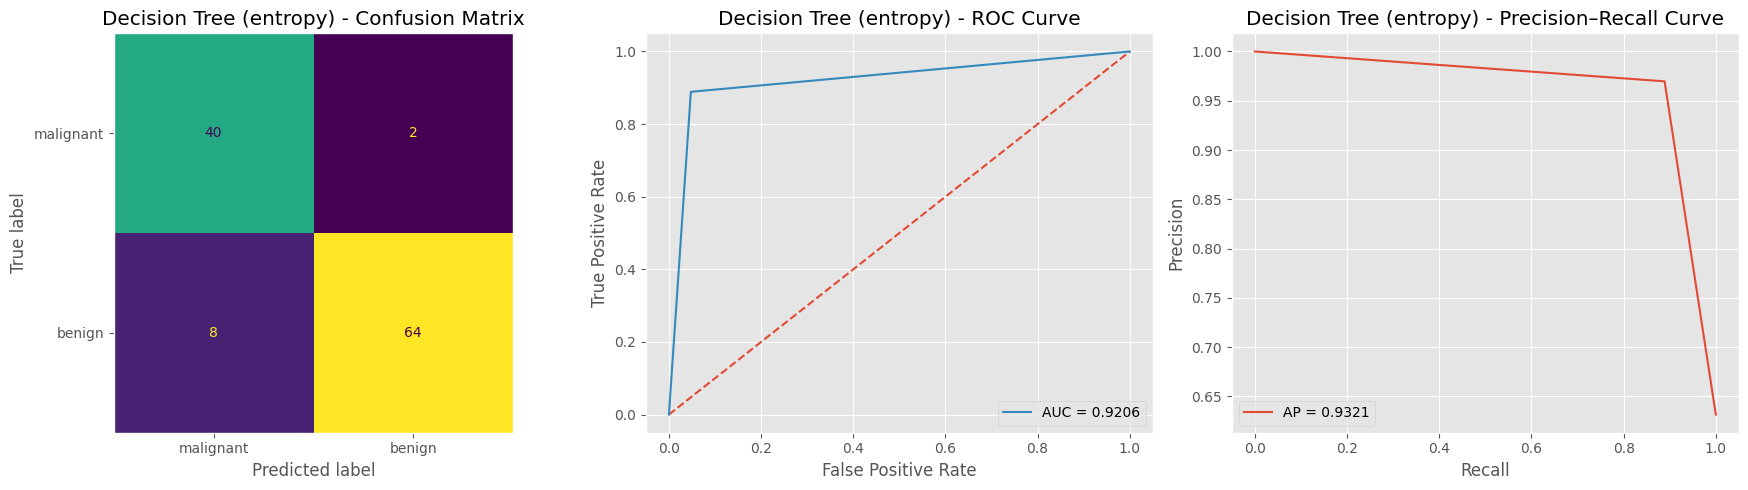

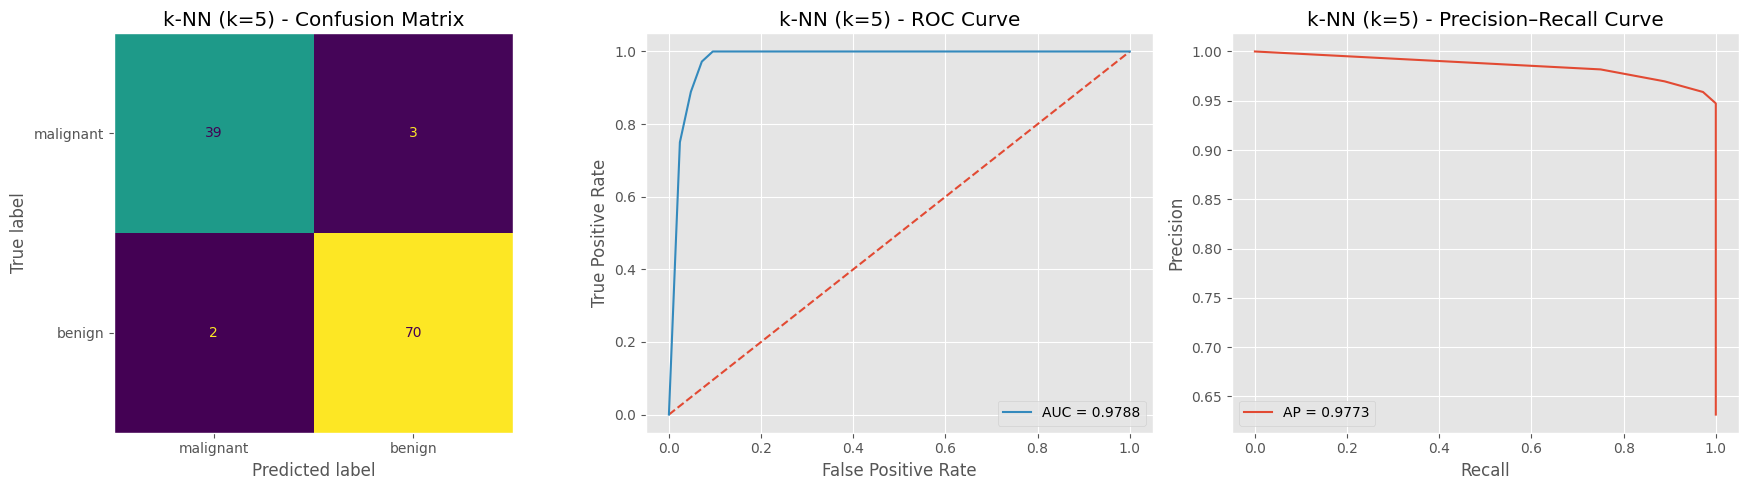

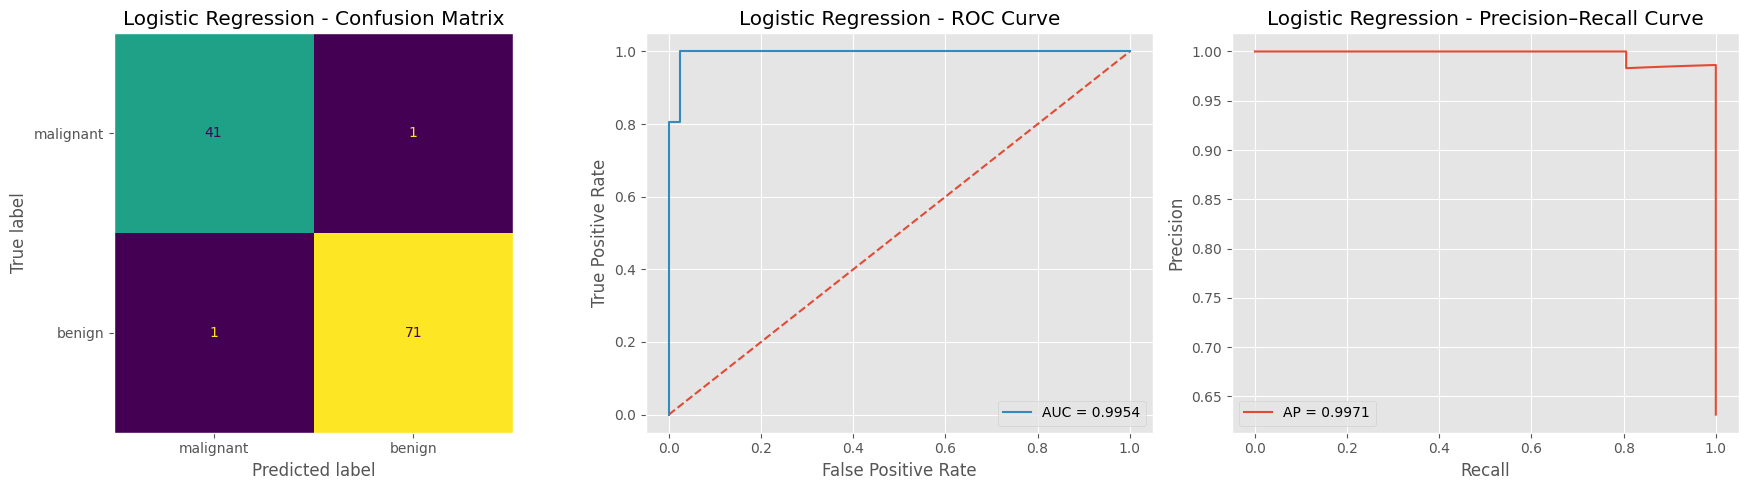

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_breast, y_breast, test_size=0.2, random_state=42, stratify=y_breast
)

models = {
    "Decision Tree (entropy)": DecisionTreeClassifier(criterion="entropy", random_state=42),
    "k-NN (k=5)": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ]),
}

rows = []
for name, model in models.items():
    model.fit(X_train, y_train)
    row = evaluate_classifier_with_plots(
        model, X_test, y_test,
        class_names=breast.target_names,
        title=name
    )
    row["Model"] = name
    rows.append(row)

In [ ]:
# Metrics Table
results_table = pd.DataFrame(rows).set_index("Model")
results_table = results_table[col_order]
display(results_table.round(3))

,Accuracy,Balanced Accuracy,Precision,Recall,F1,MCC,ROC AUC (micro),ROC AUC (macro),PR AUC/AP (micro),PR AUC/AP (macro)
Model,,,,,,,,,,
Decision Tree (entropy),0.912,0.921,0.970,0.889,0.928,0.822,0.921,0.921,0.932,0.932
k-NN (k=5),0.956,0.950,0.959,0.972,0.966,0.905,0.979,0.979,0.977,0.977
Logistic Regression,0.982,0.981,0.986,0.986,0.986,0.962,0.995,0.995,0.997,0.997


# Credit Card Fraud Detection Dataset (Unbalanced)

The Credit Card Fraud Detection dataset was selected as an example of extreme class imbalance in a real world binary classification problem. It contains a very large number of legitimate transactions and a very small proportion of fraudulent ones, with fraud representing less than one percent of the observations. This makes it a highly challenging learning scenario where standard metrics such as accuracy can be misleading.

This dataset is particularly useful for evaluating how classifiers behave when the minority class is rare and difficult to detect. It allows us to analyze the limitations of accuracy, compare ROC and Precision Recall curves, and assess the impact of imbalance handling techniques such as class weighting. Because fraud detection is a critical real world application, correctly identifying the minority class is far more important than maximizing overall accuracy. This dataset therefore provides a strong setting to study model robustness under severe imbalance.

## Data Processing

In [ ]:
# Data Loading
creditcard = fetch_openml(data_id=1597, as_frame=True)
X_credit = creditcard.data
y_credit = creditcard.target.astype(int)

# Display DataFrame
display(creditcard.frame)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Shape: (284807, 29) (284807,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,284315,1.0
1,1,492,0.0


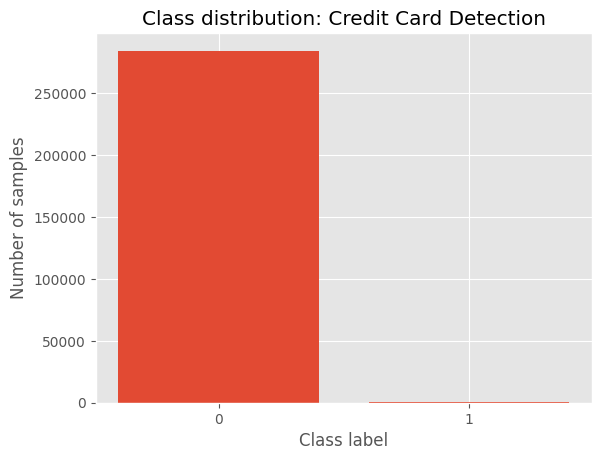

In [ ]:
# Class Distribution Analysis
class_distribution_report(X_credit, y_credit, "Credit Card Detection")

## Model Training and Evaluation

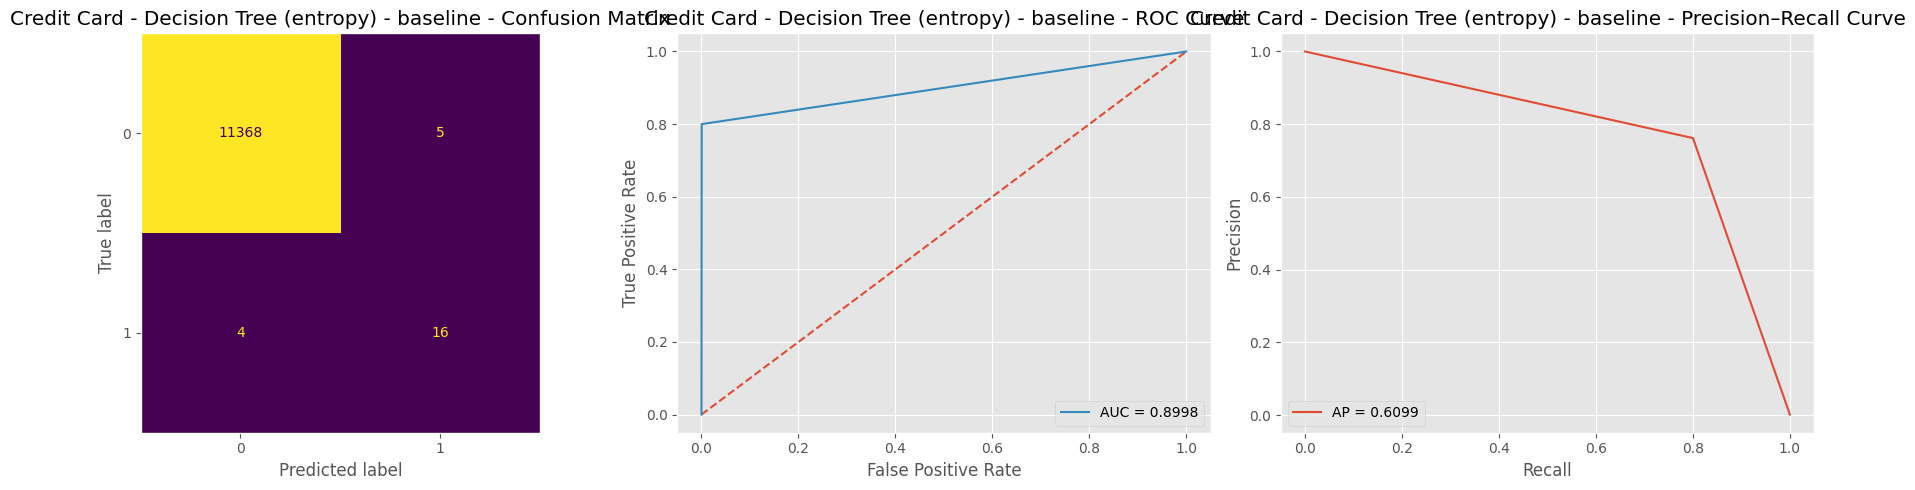

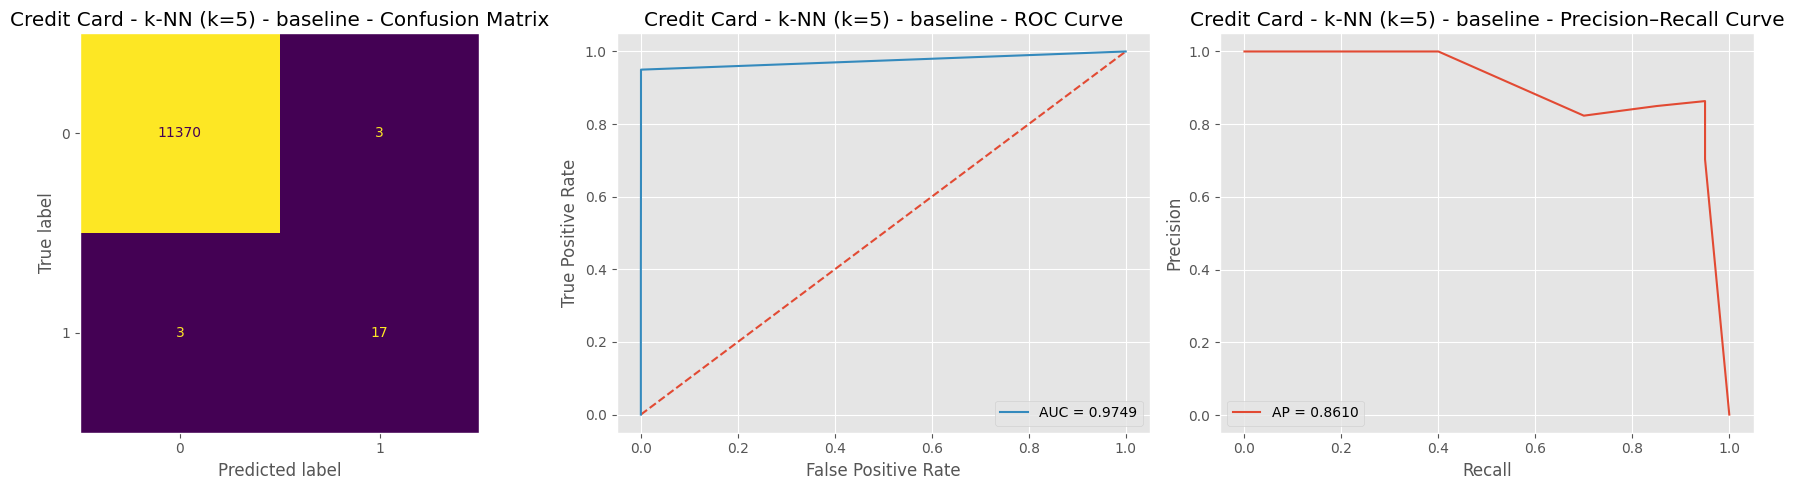

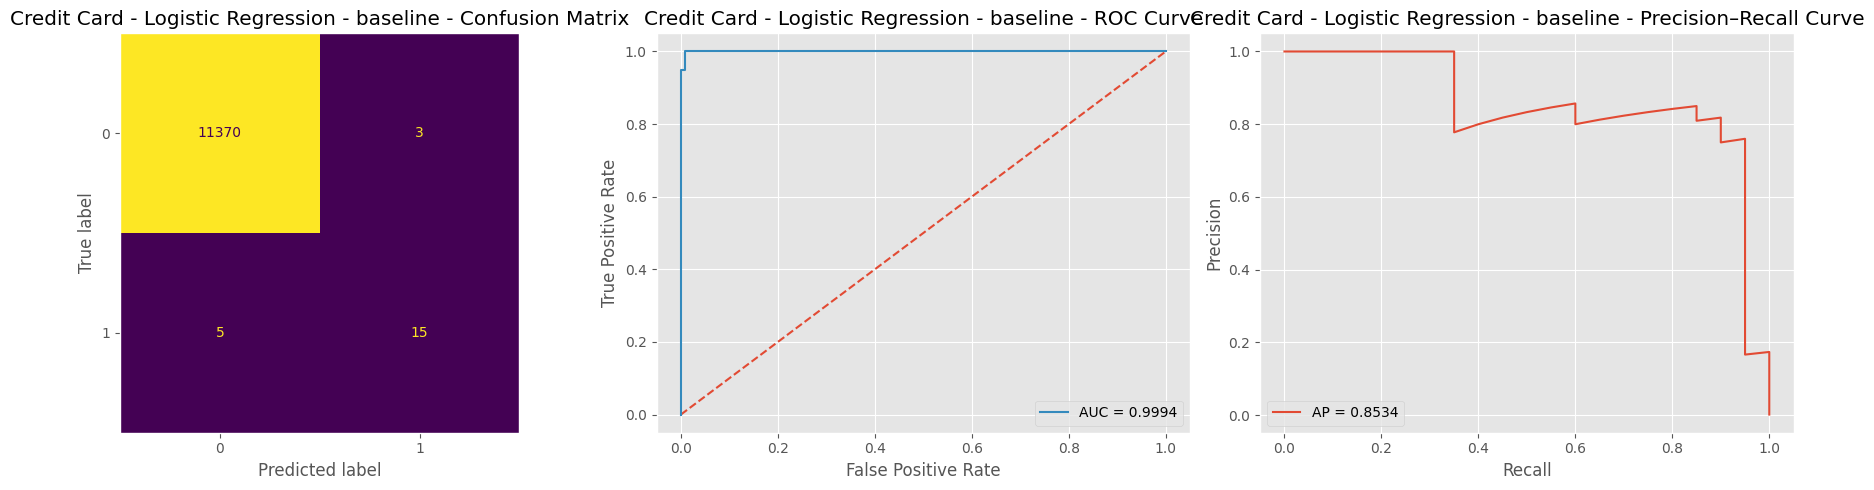

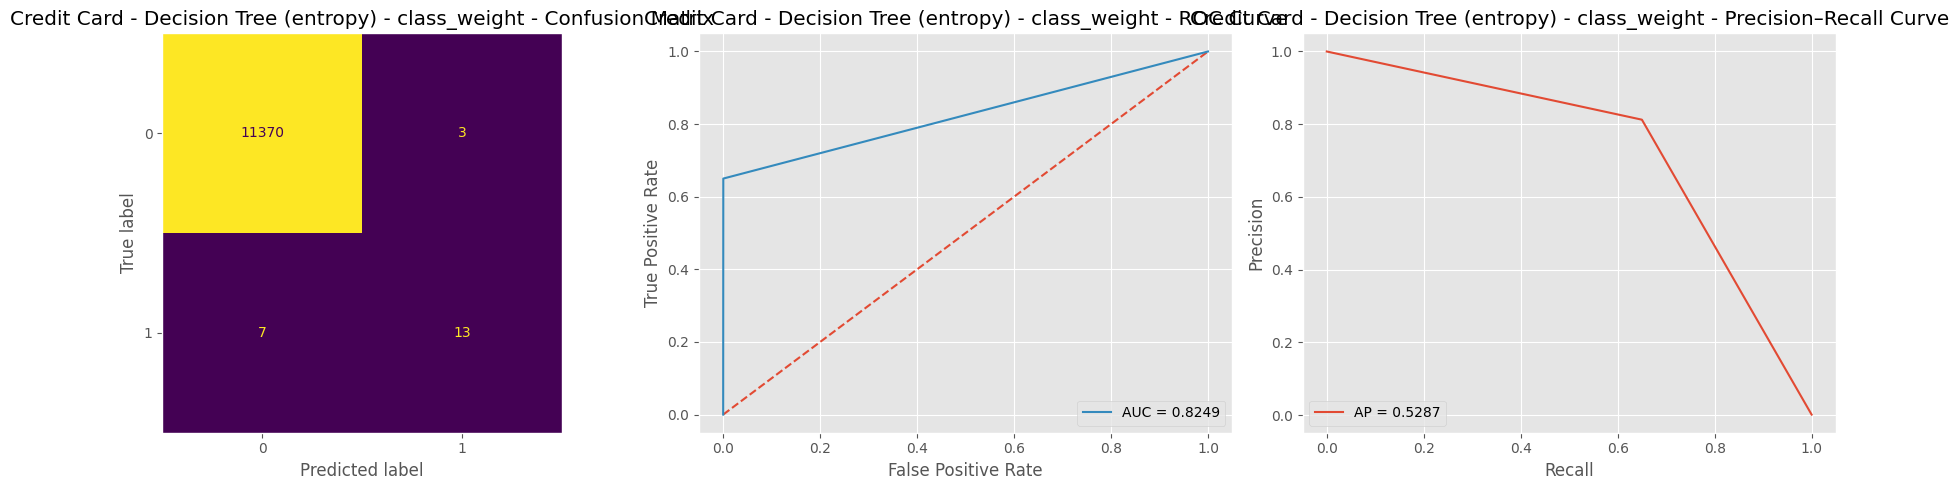

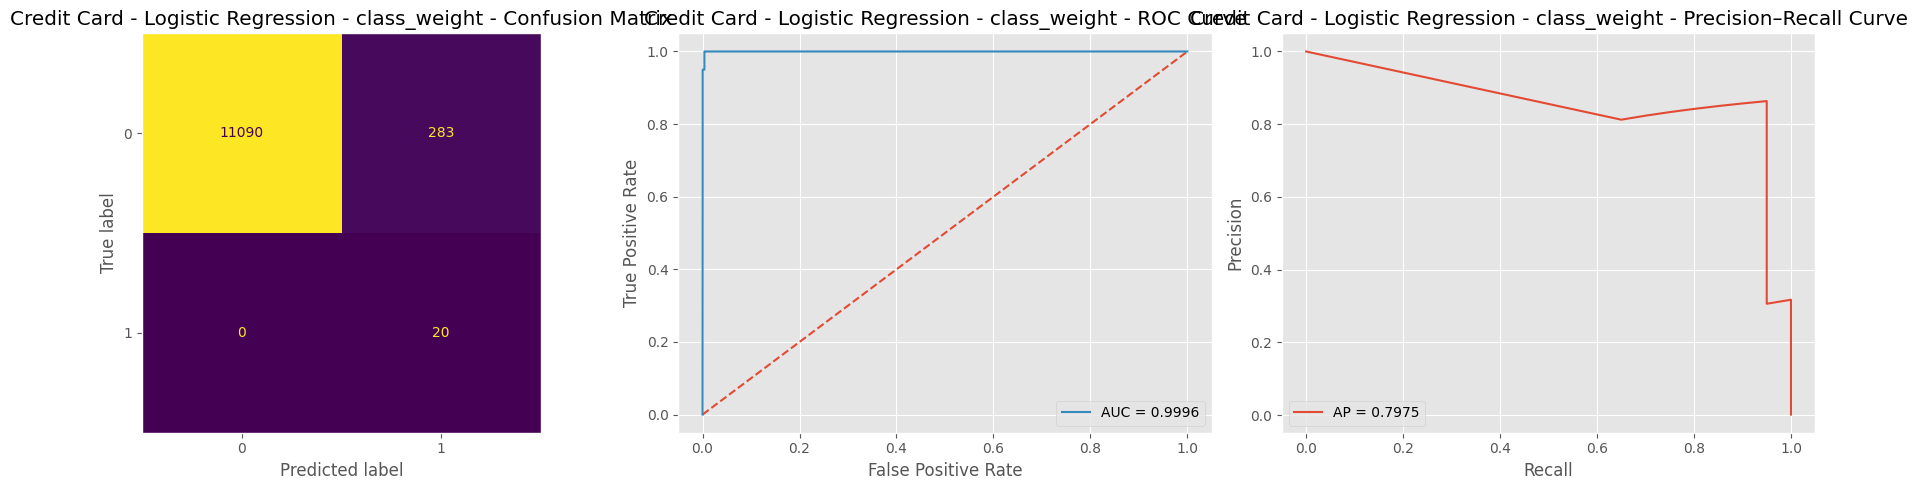

Accuracy  \
Block             Model                                              
Baseline          k-NN (k=5) - baseline                      0.999   
                  Logistic Regression - baseline             0.999   
With class_weight Logistic Regression - class_weight         0.975   
Baseline          Decision Tree (entropy) - baseline         0.999   
With class_weight Decision Tree (entropy) - class_weight     0.999   

                                                          Balanced Accuracy  \
Block             Model                                                       
Baseline          k-NN (k=5) - baseline                               0.925   
                  Logistic Regression - baseline                      0.875   
With class_weight Logistic Regression - class_weight                  0.988   
Baseline          Decision Tree (entropy) - baseline                  0.900   
With class_weight Decision Tree (entropy) - class_weight              0.825   

                                                          Precision  Recall  \
Block             Model                                                       
Baseline          k-NN (k=5) - baseline                       0.850    0.85   
                  Logistic Regression - baseline              0.833    0.75   
With class_weight Logistic Regression - class_weight          0.066    1.00   
Baseline          Decision Tree (entropy) - baseline          0.762    0.80   
With class_weight Decision Tree (entropy) - class_weight      0.812    0.65   

                                                             F1    MCC  \
Block             Model                                                  
Baseline          k-NN (k=5) - baseline                   0.850  0.850   
                  Logistic Regression - baseline          0.789  0.790   
With class_weight Logistic Regression - class_weight      0.124  0.254   
Baseline          Decision Tree (entropy) - baseline      0.780  0.780   
With class_weight Decision Tree (entropy) - class_weight  0.722  0.726   

                                                          ROC AUC (micro)  \
Block             Model                                                     
Baseline          k-NN (k=5) - baseline                             0.975   
                  Logistic Regression - baseline                    0.999   
With class_weight Logistic Regression - class_weight                1.000   
Baseline          Decision Tree (entropy) - baseline                0.900   
With class_weight Decision Tree (entropy) - class_weight            0.825   

                                                          ROC AUC (macro)  \
Block             Model                                                     
Baseline          k-NN (k=5) - baseline                             0.975   
                  Logistic Regression - baseline                    0.999   
With class_weight Logistic Regression - class_weight                1.000   
Baseline          Decision Tree (entropy) - baseline                0.900   
With class_weight Decision Tree (entropy) - class_weight            0.825   

                                                          PR AUC/AP (micro)  \
Block             Model                                                       
Baseline          k-NN (k=5) - baseline                               0.861   
                  Logistic Regression - baseline                      0.853   
With class_weight Logistic Regression - class_weight                  0.797   
Baseline          Decision Tree (entropy) - baseline                  0.610   
With class_weight Decision Tree (entropy) - class_weight              0.529   

                                                          PR AUC/AP (macro)  
Block             Model                                                      
Baseline          k-NN (k=5) - baseline                               0.861  
                  Logistic Regression - baseline                      0.

In [ ]:
use_fraction = 0.2
if use_fraction < 1.0:
    X_work, _, y_work, _ = train_test_split(
        X_credit, y_credit,
        train_size=use_fraction,
        stratify=y_credit,
        random_state=42
    )
else:
    X_work, y_work = X_credit, y_credit

X_train, X_test, y_train, y_test = train_test_split(
    X_work, y_work,
    test_size=0.2,
    random_state=42,
    stratify=y_work
)

models_baseline = {
    "Decision Tree (entropy) - baseline": DecisionTreeClassifier(criterion="entropy", random_state=42),
    "k-NN (k=5) - baseline": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]),
    "Logistic Regression - baseline": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, random_state=42))
    ]),
}

models_balanced = {
    "Decision Tree (entropy) - class_weight": DecisionTreeClassifier(
        criterion="entropy", class_weight="balanced", random_state=42
    ),
    "Logistic Regression - class_weight": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ]),
}

rows = []

for name, model in models_baseline.items():
    model.fit(X_train, y_train)
    row = evaluate_classifier_with_plots(
        model, X_test, y_test,
        pos_label=1,
        class_names=[0, 1],
        title=f"Credit Card - {name}"
    )
    row["Block"] = "Baseline"
    row["Model"] = name
    rows.append(row)

for name, model in models_balanced.items():
    model.fit(X_train, y_train)
    row = evaluate_classifier_with_plots(
        model, X_test, y_test,
        pos_label=1,
        class_names=[0, 1],
        title=f"Credit Card - {name}"
    )
    row["Block"] = "With class_weight"
    row["Model"] = name
    rows.append(row)

credit_results_table = pd.DataFrame(rows).set_index(["Block", "Model"])
credit_results_table = credit_results_table[col_order]
display(credit_results_table.round(3).sort_values(["PR AUC/AP (macro)", "MCC"], ascending=False))

# Alzheimer's Disease (OASIS) Dataset (unbalanced)

The Alzheimer's Disease dataset from OASIS was selected as an example of a multiclass classification problem with noticeable class imbalance. Unlike the credit card dataset, which is binary and extremely skewed, OASIS contains several categories with one dominant class and smaller minority classes. This structure makes it suitable for analyzing imbalance in a multiclass setting.

The dataset includes categorical features describing characteristics related to medical or diagnostic assessments. Because of the uneven distribution of classes, models may tend to favor the majority class if imbalance is not properly addressed. This dataset allows us to compare macro and micro evaluation metrics, analyze how class weighting affects performance across multiple classes, and study the behavior of classifiers in a more complex imbalance scenario. Together with the credit card dataset, it provides a complementary perspective on imbalance in both binary and multiclass problems.

## Data Processing

In [ ]:
# Data Loading
alzheimer_oasis = fetch_openml(data_id=40975, as_frame=True)
X_oasis = alzheimer_oasis.data
y_oasis = alzheimer_oasis.target

# Display DataFrame
display(alzheimer_oasis.frame)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Shape: (1728, 6) (1728,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,acc,384,0.2
1,good,69,0.0
2,unacc,1210,0.7
3,vgood,65,0.0


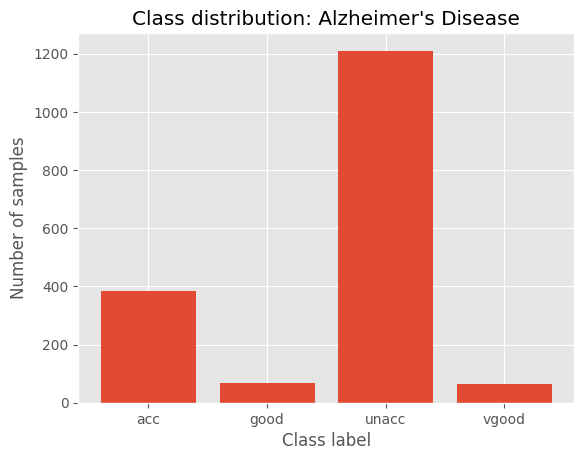

In [ ]:
# Class Distribution Analysis
class_distribution_report(X_oasis, y_oasis, "Alzheimer's Disease")

## Model Training and Evaluation

Pendiente

# Conclusions

# References

# Datasets Info (temporal, for dataset selection)

In [ ]:
# Load Wine, Breast Cancer (Diagnostic) from sklearn (Balanced)
# Load Credit Card Fraud and CThyroid from OpenML (Unbalanced)

# Iris dataset
iris = datasets.load_iris(as_frame=True)
X_iris = iris.data
y_iris = iris.target

# Wine dataset
wine = datasets.load_wine(as_frame=True)
X_wine = wine.data
y_wine = wine.target

# Breast Cancer Wisconsin (Diagnostic)
breast_cancer = datasets.load_breast_cancer(as_frame=True)
X_breast = breast_cancer.data
y_breast = breast_cancer.target

# Credit Card Fraud Detection
creditcard = fetch_openml(data_id=1597, as_frame=True)
X_credit = creditcard.data
y_credit = creditcard.target.astype(int)

# CThyroid Disease
cthyroid = fetch_openml(data_id=40499, as_frame=True)
X_cthyroid = cthyroid.data
y_cthyroid = cthyroid.target

# Alzheimer's Disease (OASIS)
alzheimer_oasis = fetch_openml(data_id=40975, as_frame=True)
X_oasis = alzheimer_oasis.data
y_oasis = alzheimer_oasis.target

# Shapes
print("Iris:", X_iris.shape, y_iris.shape)
print("Wine:", X_wine.shape, y_wine.shape)
print("Breast Cancer (Diagnostic):", X_breast.shape, y_breast.shape)
print("Credit Card Fraud:", X_credit.shape, y_credit.shape)
print("CThyroid:", X_cthyroid.shape, y_cthyroid.shape)
print("Alzheimer's Disease (OASIS):", X_oasis.shape, y_oasis.shape)

Iris: (150, 4) (150,)
Wine: (178, 13) (178,)
Breast Cancer (Diagnostic): (569, 30) (569,)
Credit Card Fraud: (284807, 29) (284807,)
CThyroid: (5500, 40) (5500,)
Alzheimer's Disease (OASIS): (1728, 6) (1728,)


Shape: (150, 4) (150,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,50,0.3
1,1,50,0.3
2,2,50,0.3


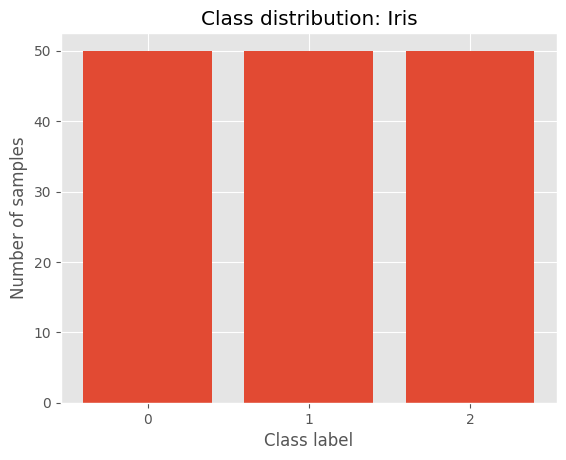

Shape: (178, 13) (178,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,59,0.3
1,1,71,0.4
2,2,48,0.3


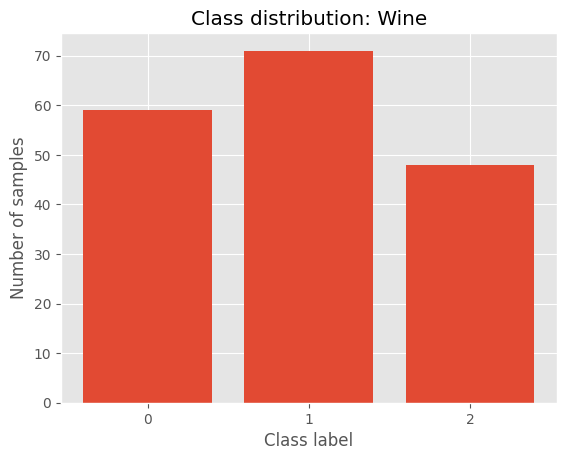

Shape: (569, 30) (569,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,212,0.4
1,1,357,0.6


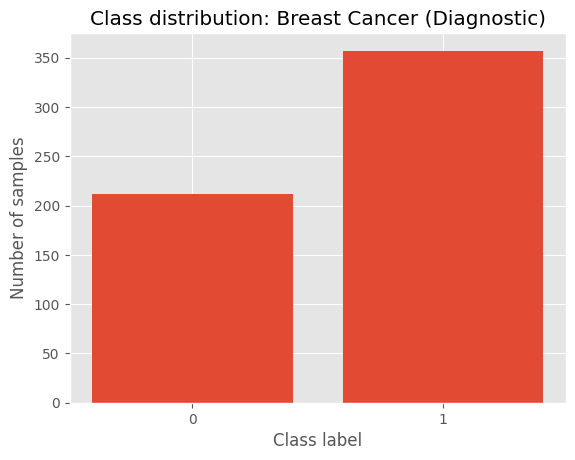

Shape: (284807, 29) (284807,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,0,284315,1.0
1,1,492,0.0


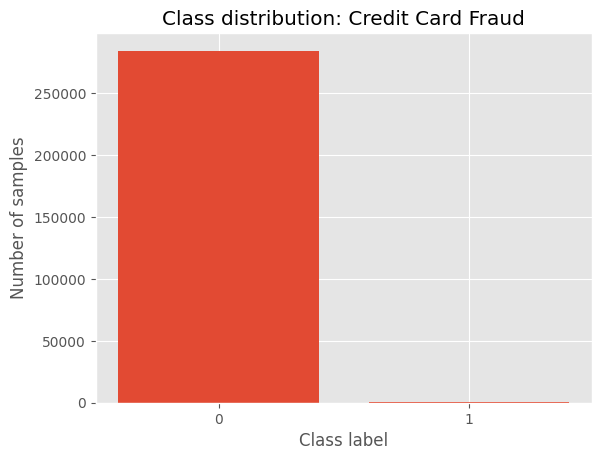

Shape: (5500, 40) (5500,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,1,500,0.1
1,10,500,0.1
2,11,500,0.1
3,2,500,0.1
4,3,500,0.1
5,4,500,0.1
6,5,500,0.1
7,6,500,0.1
8,7,500,0.1
9,8,500,0.1


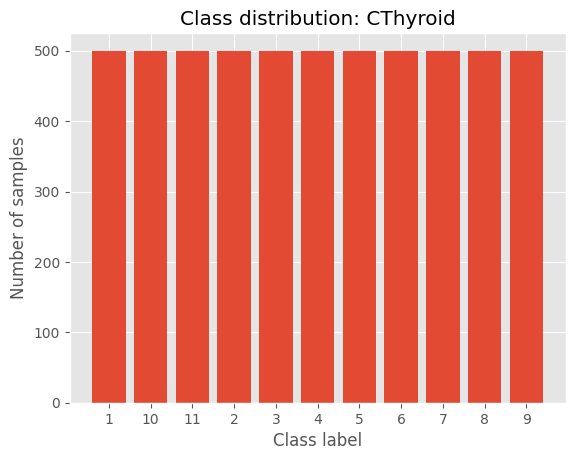

Shape: (1728, 6) (1728,)
Missing values: 0
Categorical columns: []



,Class,Count,Proportion
0,acc,384,0.2
1,good,69,0.0
2,unacc,1210,0.7
3,vgood,65,0.0


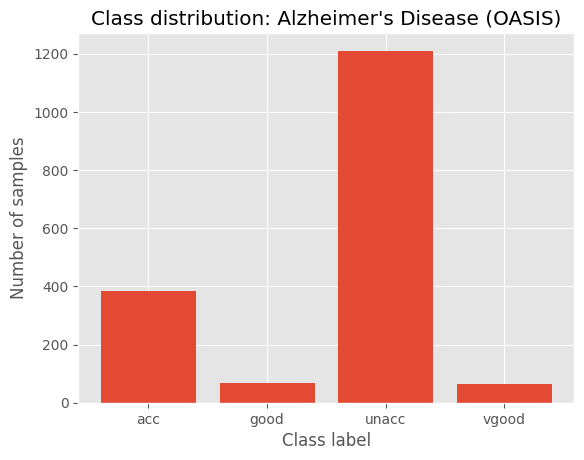

In [ ]:
class_distribution_report(X_iris, y_iris, "Iris")
class_distribution_report(X_wine, y_wine, "Wine")
class_distribution_report(X_breast, y_breast, "Breast Cancer (Diagnostic)")
class_distribution_report(X_credit, y_credit, "Credit Card Fraud")
class_distribution_report(X_cthyroid, y_cthyroid, "CThyroid")
class_distribution_report(X_oasis, y_oasis, "Alzheimer's Disease (OASIS)")